In [1]:
import sys
import os
current = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.join(current))

In [2]:
from typing import List

In [3]:
import numpy as np
import fiftyone as fo
from fiftyone import ViewField as F
from dataloaders import HorizonDataset
from torch.utils.data import DataLoader
from torchvision import transforms as T
from utils.augmentations import LetterBox
from utils_horizon import pitch_and_theta_from_points

In [4]:
def transforms(img, target: List[float]):
    # TODO: complete this function
    # img shape: hwc
    # target: array of [x1y1x2y2] in [0,1]
    # letterbox transform (640 x 640)
    # target transform: points --> pitch, theta

    # transform target
    target = np.array(target).flatten()
    h, w = img.shape[:2]
    size = (640, 640) #hw

    resize_factor = min(size[0]/h, size[1]/w)
    target *= resize_factor
    new_h = h*resize_factor
    new_w = w*resize_factor

    # calculate in absolute values in range of size
    # TODO: maybe there is a better way to do this w/o going to absolute values?
    target[[0,2]]*=new_w
    target[[1,3]]*=new_h

    pad_h = (size[0] - new_h)//2
    pad_w = (size[1] - new_w)//2

    target[[0,2]] += pad_w
    target[[1,3]] += pad_h

    # normalize target with respect to new image size
    target[[0,2]] /= size[1]
    target[[1,3]] /= size[0]

    # transform image
    img = T.Compose(
        [
            LetterBox(size=size),
            T.ToTensor(),
        ]
    )(img)

    pitch, theta = pitch_and_theta_from_points(*target)

    return img, np.array([pitch, theta])


dataset = HorizonDataset(
    dataset=(fo.load_dataset("thermal_quickstart_8bit_minmax_10k")
             .match(F("ground_truth_pl.polylines.closed") == [False])),  # only open polylines
    transforms=transforms
)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

[Pitch, theta] [    0.89687     0.54972]


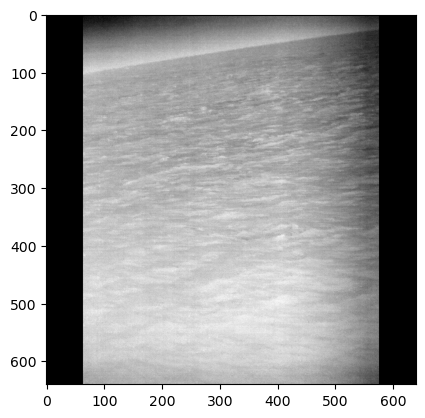

[Pitch, theta] [    0.89003     0.48301]


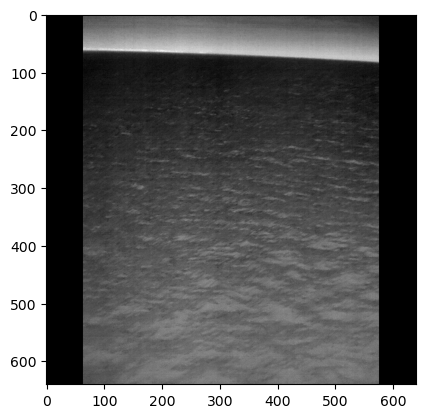

[Pitch, theta] [    0.68516     0.49813]


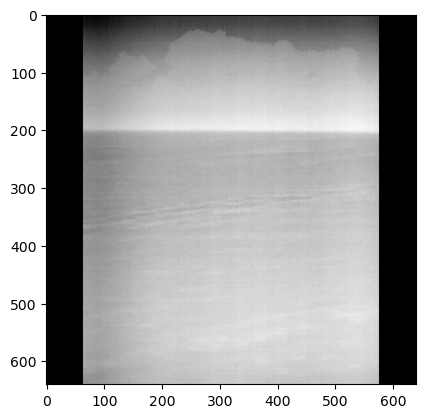

[Pitch, theta] [     0.7968     0.50752]


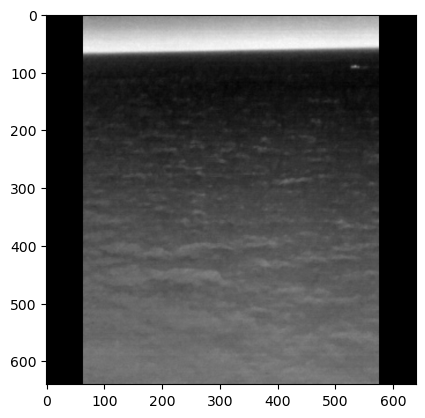

[Pitch, theta] [    0.77574     0.48444]


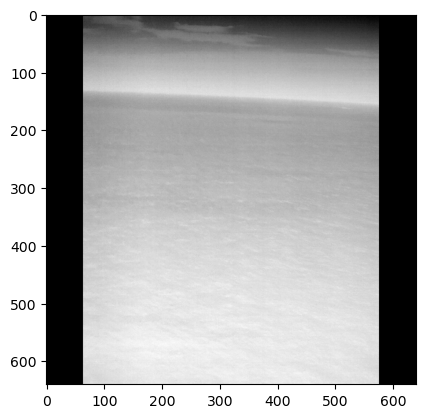

[Pitch, theta] [    0.72578     0.50559]


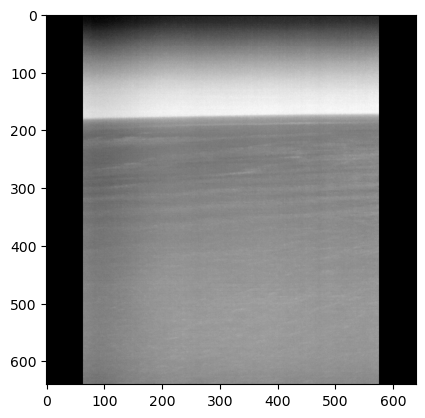

[Pitch, theta] [    0.67811      0.4975]


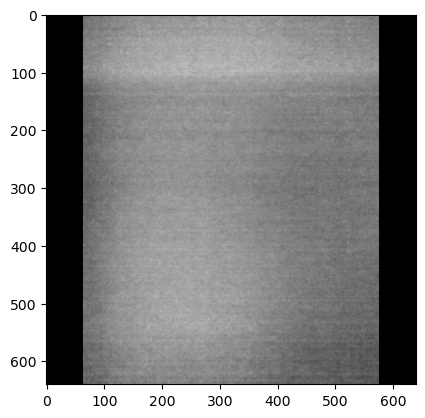

[Pitch, theta] [    0.71407     0.50125]


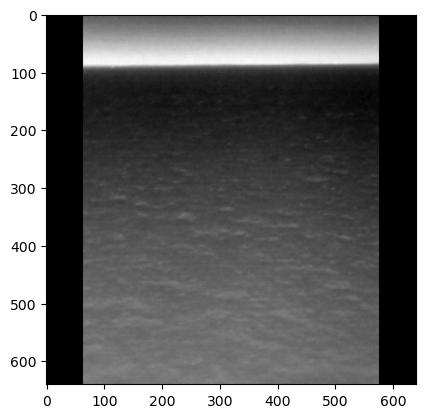

[Pitch, theta] [    0.90083     0.52061]


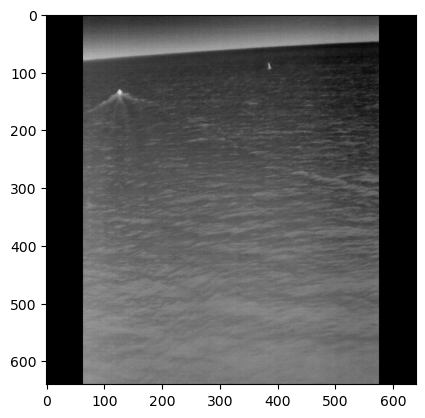

[Pitch, theta] [    0.66328     0.52296]


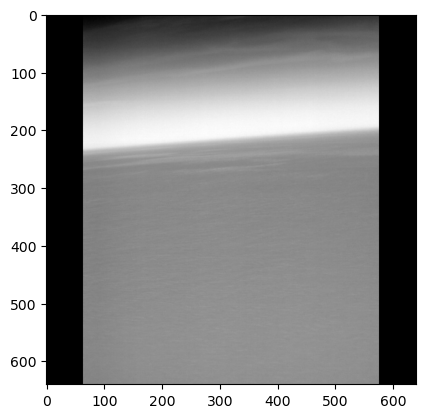

In [18]:
# Have a look at a few examples in the dataset to assess the transformed images and targets
import matplotlib.pyplot as plt
for i in range(10):
    idx = np.random.randint(low=0, high=len(dataset))
    sample = dataset[i]
    print("[Pitch, theta]", sample[1])
    plt.imshow(sample[0].numpy().transpose(1,2,0))
    plt.show()

In [16]:
for img, target in dataloader:
    # TODO: reconstruct image (visible 8bit)
    # TODO: go from pitch, theta --> points
    # TODO: plot horizon on image
    print(img.shape, target.shape)
    break

torch.Size([1, 1, 512, 512]) torch.Size([1, 2, 2])


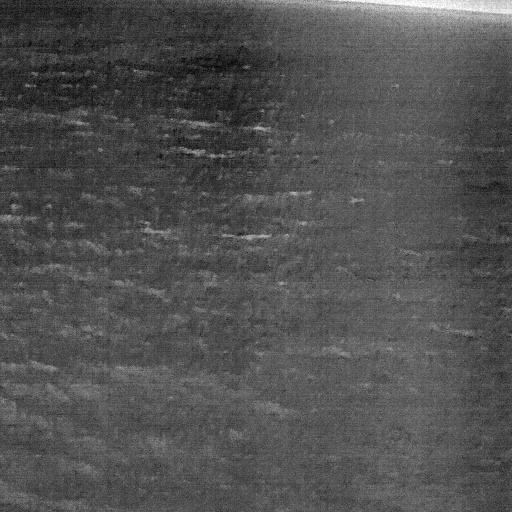

In [22]:
from PIL import Image

Image.fromarray((img.squeeze().numpy() * 255).astype(np.uint8))